***Consider the agent will start at s0 and terminate at s3. Searching '1000' starting states***

In [1]:
# importing packages
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit_aer.backends import AerSimulator
from qiskit.circuit.library import RYGate
from qiskit.circuit import Parameter
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from typing import List
import pandas as pd
from matplotlib.lines import Line2D
import os
import pickle

In [21]:
# Classical environment

class ClassicToyEnv:
    
    def __init__(self):
              
        # ========================================
        # MDP definition
        self.nS= 4 # Number of MDP states
        self.nA= 2 # Number of MDP actions
        self.nR= 4 # Number of possible rewards
        
        # Transition function
        self.T= np.zeros((self.nS, self.nA, self.nS))
        self.T[0, 0, 1]= 0.6
        self.T[0, 0, 2]= 0.4
        self.T[0, 1, 0]= 0.1 
        self.T[0, 1, 1]= 0.9 
        self.T[1, 0, 0]= 0.2 
        self.T[1, 0, 1]= 0.8
        self.T[1, 1, 2]= 0.7
        self.T[1, 1, 3]= 0.3
        self.T[2, 0, 0]= 0.3
        self.T[2, 0, 2]= 0.7
        self.T[2, 1, 1]= 0.2
        self.T[2, 1, 3]= 0.8
        self.T[3, 0, 2]= 0.6
        self.T[3, 0, 3]= 0.4
        self.T[3, 1, 3]= 1.0

        # Reward function
        self.R= np.array([10, -5, 1, -10])        
    
    # returns the number of states
    def numberOfStates(self):
        return self.nS
       
    # returns the number of actions 
    def numberOfActions(self):
        return self.nA
    
    # Returns the transition probability from state s and action a to state sp
    def transitionProb(self, s, a, sp):
        return self.T[s, a, sp]
    
    
    # Returns the reward value for the transition (s,a)->sp, i.e. r(s,a,sp)
    def rewardValue(self, s, a, sp):
        return self.R[sp]

In [3]:
# Quantum Environment for Two State Transitions with Return

class QuantumToyEnv(ClassicToyEnv):
    
    def __init__(self):
        super().__init__()
    
        # ========================================
        # Quantum MDP representation 
        self.nqS= 2 # Number of qubits for state representation= log2(nS)
        self.nqA= 1 # Number of qubits required for action representation= log2(nA)
        self.nqR= 2 # Number of qubits for reward representation= log2(nR)
        self.nqRt = 4 # Number of qubits for return

        # Quantum Registers for MDP 2-state transition 
        self.qS0= QuantumRegister(self.nqS, name='t0_qS') # Quantum Register to store input environment states
        self.qSp0= QuantumRegister(self.nqS, name='t0_qSp') # Quantum Register to store output environment states
        self.qA0= QuantumRegister(self.nqA, name='t0_qA') # Quantum Register to store actions
        self.qR0= QuantumRegister(self.nqR, name='t0_qR') # Quantum Register to store rewards
        
        self.qS1= QuantumRegister(self.nqS, name='t1_qS') # Quantum Register to store input environment states
        self.qSp1= QuantumRegister(self.nqS, name='t1_qSp') # Quantum Register to store output environment states
        self.qA1= QuantumRegister(self.nqA, name='t1_qA') # Quantum Register to store actions
        self.qR1= QuantumRegister(self.nqR, name='t1_qR') # Quantum Register to store rewards
        
        self.qS2= QuantumRegister(self.nqS, name='t2_qS') # Quantum Register to store input environment states
        self.qSp2= QuantumRegister(self.nqS, name='t2_qSp') # Quantum Register to store output environment states
        self.qA2= QuantumRegister(self.nqA, name='t2_qA') # Quantum Register to store actions
        self.qR2= QuantumRegister(self.nqR, name='t2_qR') # Quantum Register to store rewards
        
        # Quantum Registers for Return
        self.qRt= QuantumRegister(self.nqRt, name='qRt') # Quantum Register to store return
        
        # Classical Registers
        self.cRt= ClassicalRegister(4, name='cR') # Classical Register to store measured return

        # Quantum Circuit to store a cycle of an MDP
        # self.qc= QuantumCircuit(self.qS0, self.qA0, self.qSp0, self.qR0,
        #                         self.qS1, self.qA1, self.qSp1, self.qR1,
        #                         self.qS2, self.qA2, self.qSp2, self.qR2,
        #                         self.qRt, self.cRt)
        self.qc= QuantumCircuit(self.qS0, self.qA0, self.qSp0, self.qR0,
                                self.qS1, self.qA1, self.qSp1, self.qR1,
                                self.qS2, self.qA2, self.qSp2, self.qR2,
                                self.qRt)

        # for t = 0 , initial step      
        # Us implementation: Appends Us to self.qc
        self.__Us_0(self.qc, self.qS0)
        
        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA0)

        # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS0, self.qA0, self.qSp0)
                
        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp0, self.qR0)
        
        # for t = 1
        # Us implementation: Appends Us to self.qc
        self.__Us(self.qc, self.qSp0, self.qS1)
        
        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA1)

        # # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS1, self.qA1, self.qSp1)
                
        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp1, self.qR1)
        
        # for t = 2
        # Us implementation: Appends Us to self.qc
        self.__Us(self.qc, self.qSp1, self.qS2)

        # Ua implementation: Appends Ua to self.qc
        self.__Ua(self.qc, self.qA2)

        # # Ut implementation: Appends transition function to self.qc
        self.__Ut(self.qc, self.qS2, self.qA2, self.qSp2)

        # Ur implementation: Appends Reward function to self.qc
        self.__Ur(self.qc, self.qSp2, self.qR2)
        

    # Implementation of the QSample encoding
    # param probs: Probabilities of each amplitude
    # param qc: The quantum circuit where to append the encoding
    # param qS: Quantum register to store current env. state
    # param qA: Quantum register to store current action
    # param qSp: Quantum register to store next env. state
    # param control_s: str with values 0/1 to set the control state coming from qS
    # param control_a: str with values 0/1 to set the control state coming from qA
    # control_sp: Internal parameter to track recursion
    # currentQ: Internal parameter to track recursion
    #
    # The circuit qc is modified and the QSample is appender to the end
    def __QSampleNextState(self, probs, qc, qS, qA, qSp, control_s, control_a, control_sp= '', currentQ=0):
        
        all_controls= control_s + control_a + control_sp
        
        # Find control qubits
        controlsS= []
        for i in range(len(qS)):
            controlsS.append(qS[i])
        controlsA= []
        for i in range(len(qA)):
            controlsA.append(qA[i])
        controlsSp= []
        for i in range(currentQ):
            controlsSp.append(qSp[i])
        
        
        # Base case: End of recursion
        if currentQ>=len(qSp):
            return
        
        else: # General case
        
            add_prob= np.sum(probs)
            if add_prob > 0:
                current_prob= np.sum(probs[len(probs)//2:])/add_prob
                angle= 2*np.arcsin(np.sqrt(current_prob))
                
                # Make custom controlled CRY gate 
                cry= RYGate(angle).control(num_ctrl_qubits=len(all_controls), 
                                             ctrl_state= all_controls)
                
                qc.append(cry, [*controlsSp, *controlsA, *controlsS, qSp[currentQ]])
        
            self.__QSampleNextState(probs[:len(probs)//2], qc, qS, qA, qSp, 
                    control_s= control_s,
                    control_a= control_a,
                    control_sp=control_sp+'0', currentQ=currentQ+1)
            self.__QSampleNextState(probs[len(probs)//2:], qc, qS, qA, qSp, 
                    control_s= control_s,
                    control_a= control_a,
                    control_sp=control_sp+'1', currentQ=currentQ+1)
    

    # Circuit to set input environment state
    # param qc: The quantum circuit to be updated
    # param qS: Quantum register to store env state
    # param params: Parameters for the circuit
    # 
    # The qc is updated with the Us circuit at the end    
    # for state in superposition
    def __Us_0(self, qc, qS):
        for i in range(len(qS)):
            qc.h(qS[i])
        qc.barrier()
        
    def __Us(self, qc, qSp, qS):   
        for i in range(len(qS)):
           if i == 1:
             qc.cx(qSp[i],qS[i-1])
           else:
            qc.cx(qSp[i],qS[i+1])
        qc.barrier()
        
    # Circuit to set input action
    # param qc: The quantum circuit to be updated
    # param qA: Quantum register to store agent action
    # param params: Parameters for the circuit
    # 
    # The qc is updated with the Ua circuit at the end        
    def __Ua(self, qc, qA):
        for i in range(len(qA)):
            qc.h(qA[i])
        qc.barrier()
    
    # Circuit to implement transition function
    # param qc: The quantum circuit to be updated
    # param qS: Quantum register to store env state
    # param qA: Quantum register to store agent action
    # param qSp: Quantum register to store env next state
    # 
    # The qc is updated with the Ut circuit at the end
    def __Ut(self, qc, qS, qA, qSp):
        
        for s in range(self.nS): 
            for a in range(self.nA):
                
                # Conditionals for input state s
                binS= bin(s)[2:][::-1]
                while len(binS)<self.nqS:
                    binS+= '0'
                binS= binS[::-1]
                
                # Conditionals for input action a
                binA= bin(a)[2:][::-1]
                while len(binA)<self.nqA:
                    binA+= '0'
                binA= binA[::-1]
        
                # Transition Function P(s,a)
                probs= self.T[s, a]
                self.__QSampleNextState(probs, self.qc, qS, qA, qSp, 
                        control_s=binS, 
                        control_a=binA)
                self.qc.barrier()

    
    # Circuit to implement reward function
    # param qc: The quantum circuit to be updated
    # param qSp: Quantum register to store env next state
    # param qR: Quantum register to store rewards
    # 
    # The qc is updated with the Ur circuit at the end
    def __Ur(self, qc, qSp, qR):
        
        # Hard-coded for example MDP
        for i in range(len(qSp)):
            qc.cx(qSp[i], qR[i])
        self.qc.barrier()    
        
##################################################################################
    
# Circuit to implement return function
def __URt(qc,t0_qR0, t0_qR1, t1_qR0,t1_qR1,t2_qR0,t2_qR1,qRt_0,qRt_1,qRt_2,qRt_3):
  ## return oracle

  #### for LSB output qubit q6
    qc.cx(t0_qR0,qRt_0)
    qc.cx(t1_qR0,qRt_0)
    qc.cx(t2_qR0,qRt_0)
    qc.barrier()

  #### for output qubit q7
    qc.cx(t0_qR1,qRt_1)
    qc.cx(t1_qR1,qRt_1)
    qc.cx(t2_qR1,qRt_1)
  ## carry-in part
    qc.ccx(t0_qR0,t1_qR0,qRt_1)
    qc.ccx(t0_qR0,t2_qR0,qRt_1)
    qc.ccx(t1_qR0,t2_qR0,qRt_1)
    qc.barrier()


  #### for output qubit q8 (carry-out qbit)
  # when no carry-in bit from LSB
    qc.ccx(t0_qR1,t1_qR1,qRt_2)
    qc.ccx(t0_qR1,t2_qR1,qRt_2)
    qc.ccx(t1_qR1,t2_qR1,qRt_2)

  # when carry-in bit from LSB
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
  ## carry-in and single one qubit
    qc.mcx([t0_qR0,t1_qR0,t0_qR1],[qRt_2])
    qc.mcx([t0_qR0,t1_qR0,t1_qR1],[qRt_2])
    qc.mcx([t0_qR0,t1_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t0_qR0,t2_qR0,t0_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t1_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t1_qR0,t2_qR0,t0_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t1_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t2_qR1],[qRt_2])
    
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_2])
    
    qc.barrier()

  ### for output qubit q9 (carry-out qubit)
    qc.mcx([t0_qR0,t1_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.mcx([t0_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.mcx([t1_qR0,t2_qR0,t0_qR1,t1_qR1,t2_qR1],[qRt_3])
    qc.barrier()


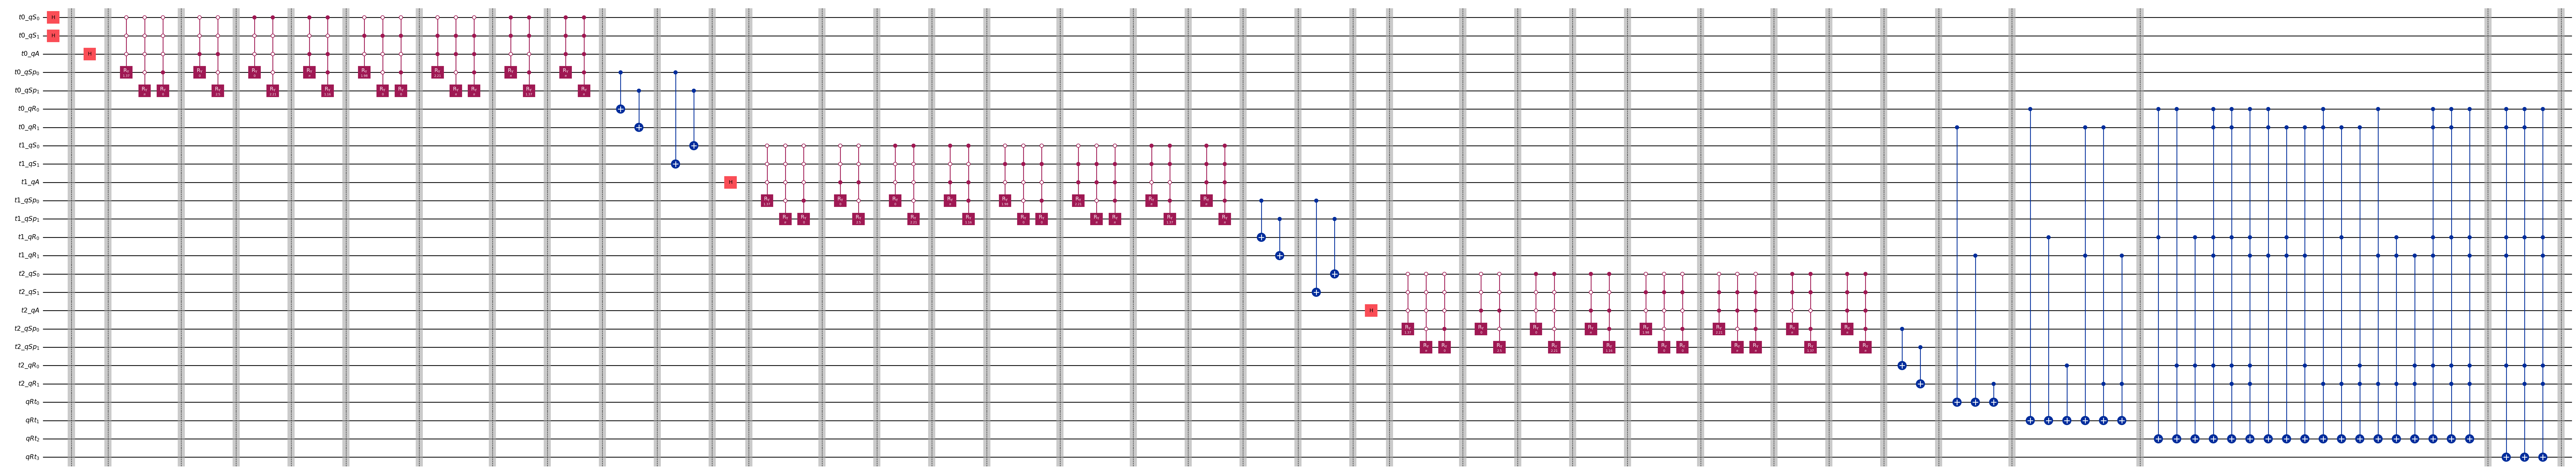

In [4]:
# Instantiate environment
env_R= QuantumToyEnv() 

### implement return function to "env" MDP circuit
__URt(env_R.qc, env_R.qR0[1], env_R.qR0[0], env_R.qR1[1],env_R.qR1[0],env_R.qR2[1],env_R.qR2[0],env_R.qRt[0],env_R.qRt[1],env_R.qRt[2],env_R.qRt[3]) 

mdp_two_states_return = env_R.qc
mdp_two_states_return.draw('mpl', fold= 1)

In [5]:
qreg = QuantumRegister(25, name ='g')
oracle = QuantumCircuit(qreg, name = 'Grover')
oracle.x([23,22,21,1,0])
oracle.h(24)
oracle.mcx([23,22,21,18,17,1,0],24)
oracle.h(24)
oracle.x([23,22,21,1,0])
# oracle.draw('mpl')

In [6]:
env_R.qc = env_R.qc.compose(oracle, env_R.qc.qubits)

env_R.qc.barrier()
# env_R.qc.draw('mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=25, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 't0_qS'), 0), Qubit(QuantumRegister(2, 't0_qS'), 1), Qubit(QuantumRegister(1, 't0_qA'), 0), Qubit(QuantumRegister(2, 't0_qSp'), 0), Qubit(QuantumRegister(2, 't0_qSp'), 1), Qubit(QuantumRegister(2, 't0_qR'), 0), Qubit(QuantumRegister(2, 't0_qR'), 1), Qubit(QuantumRegister(2, 't1_qS'), 0), Qubit(QuantumRegister(2, 't1_qS'), 1), Qubit(QuantumRegister(1, 't1_qA'), 0), Qubit(QuantumRegister(2, 't1_qSp'), 0), Qubit(QuantumRegister(2, 't1_qSp'), 1), Qubit(QuantumRegister(2, 't1_qR'), 0), Qubit(QuantumRegister(2, 't1_qR'), 1), Qubit(QuantumRegister(2, 't2_qS'), 0), Qubit(QuantumRegister(2, 't2_qS'), 1), Qubit(QuantumRegister(1, 't2_qA'), 0), Qubit(QuantumRegister(2, 't2_qSp'), 0), Qubit(QuantumRegister(2, 't2_qSp'), 1), Qubit(QuantumRegister(2, 't2_qR'), 0), Qubit(QuantumRegister(2, 't2_qR'), 1), Qubit(QuantumRegister(4, 'qRt'), 0), Qubit(QuantumRegister(4, 'qRt'),

In [7]:
# customized diffuser
qreg = QuantumRegister(env_R.qc.num_qubits, name ='d')
diffuser = QuantumCircuit(qreg, name = 'Diffuser')
nqubits = diffuser.num_qubits

diffuser.x([nqubits-25,nqubits-24])

diffuser.h([nqubits-25,nqubits-24,nqubits-23])
diffuser.x([nqubits-25,nqubits-24,nqubits-23])
diffuser.h(nqubits-19)
diffuser.mcx([nqubits-25,nqubits-24,nqubits-23],nqubits-19)
diffuser.h(nqubits-19)
diffuser.x([nqubits-25,nqubits-24,nqubits-23])
diffuser.h([nqubits-25,nqubits-24,nqubits-23])
diffuser.barrier()

diffuser.h([nqubits-18,nqubits-17,nqubits-16])
diffuser.x([nqubits-18,nqubits-17,nqubits-16])
diffuser.h(nqubits-12)
diffuser.mcx([nqubits-18,nqubits-17,nqubits-16],nqubits-12)
diffuser.h(nqubits-12)
diffuser.h(nqubits-13)
diffuser.mcx([nqubits-18,nqubits-17,nqubits-16],nqubits-13)
diffuser.h(nqubits-13)
diffuser.x([nqubits-18,nqubits-17,nqubits-16])
diffuser.h([nqubits-18,nqubits-17,nqubits-16])
diffuser.barrier()

diffuser.h([nqubits-11,nqubits-10,nqubits-9])
diffuser.x([nqubits-11,nqubits-10,nqubits-9])
diffuser.h(nqubits-5)
diffuser.mcx([nqubits-11,nqubits-10,nqubits-9],nqubits-5)
diffuser.h(nqubits-5)
diffuser.h(nqubits-6)
diffuser.mcx([nqubits-11,nqubits-10,nqubits-9],nqubits-6)
diffuser.h(nqubits-6)
diffuser.x([nqubits-11,nqubits-10,nqubits-9])
diffuser.h([nqubits-11,nqubits-10,nqubits-9])
diffuser.barrier()

diffuser.h([nqubits-1,nqubits-2,nqubits-3,nqubits-4])
diffuser.mcx([nqubits-19,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-1)
diffuser.mcx([nqubits-19,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-2)
diffuser.mcx([nqubits-19,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-3)
diffuser.mcx([nqubits-19,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-4)
diffuser.h([nqubits-1,nqubits-2,nqubits-3,nqubits-4])

# diffuser.draw('mpl')

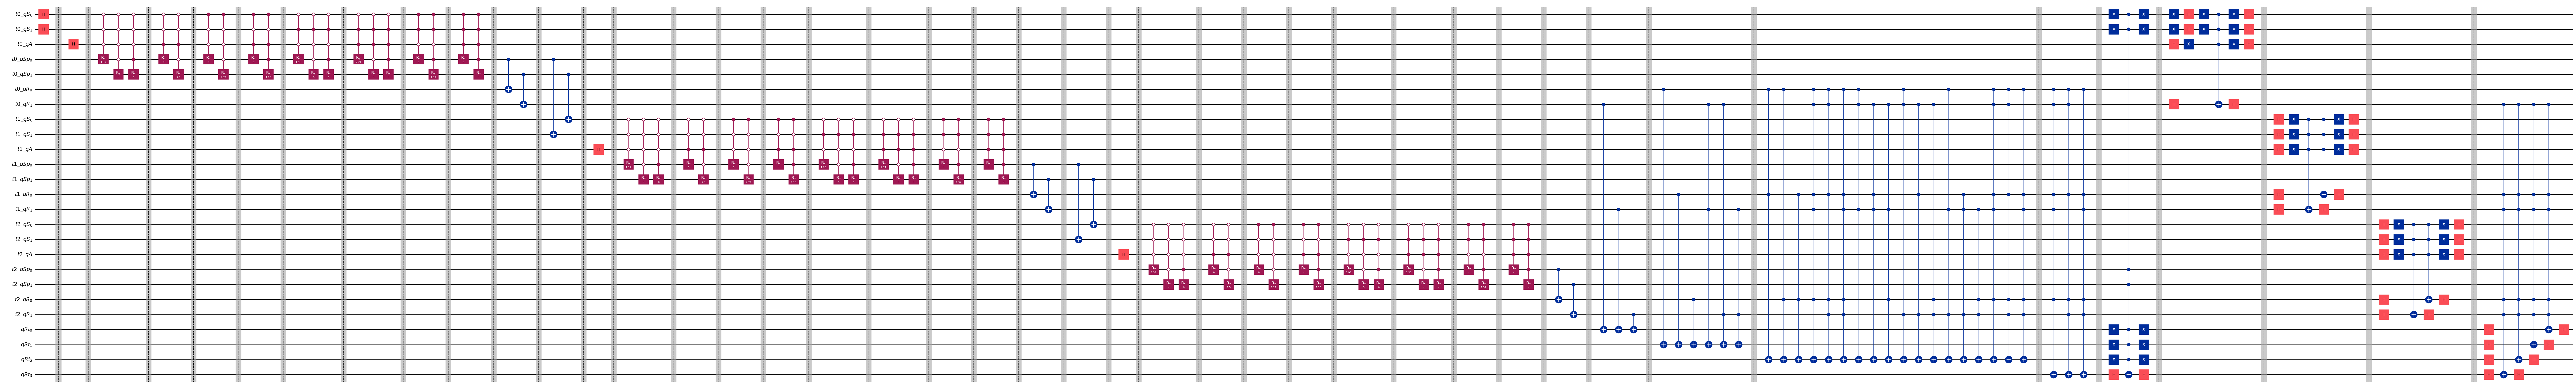

In [8]:
env_R.qc = env_R.qc.compose(diffuser, env_R.qc.qubits)
env_R.qc.draw('mpl', fold=1)

In [9]:
# classical measurement
env_R.qc.measure_all()

In [10]:
backend = AerSimulator(method = 'statevector')
results_grover_1000 = backend.run(transpile(env_R.qc, backend), memory=True).result()
memory_grover_1000 = results_grover_1000.get_memory(env_R.qc)
counts_Grover_1000= results_grover_1000.get_counts()    
# print(counts_Grover_1000)
# plot_histogram(counts_Grover_1000, title= 'Classical Measurement of Two-State Transitions - Grover Search-1000')

In [14]:
# Correcting Next state qubits and reward qubits order
print ('counts_Grover_1000:',counts_Grover_1000) 

# Function to reverse the four most significant bits
def reverse_qubit_order_msb(value):
    if len(value) >= 4:
        most_significant_four = value[:4]
        rest = value[4:]
        reversed_most_significant_four = most_significant_four[::-1]
        return reversed_most_significant_four + rest
    return value

def correct_qubit_order(value):
     if len(value) >= 21:
         # return
         rt = value[:4] 
         # for t2
         t2 = value[4:11]
         t2_msb = reverse_qubit_order_msb(t2)
         # for t1
         t1 = value[11:18]
         t1_msb = reverse_qubit_order_msb(t1)
         # for t0
         t0 = value[18:]
         t0_msb = reverse_qubit_order_msb(t0)
         return rt+t2_msb+ t1_msb + t0_msb
     return value

# Create a new dictionary with modified values
modified_counts_Grover_1000 = {correct_qubit_order(key): value for key, value in counts_Grover_1000.items()}
# print('modified_counts_Grover_1000:',modified_counts_Grover_1000) ## Next state qubits and reward qubits are in correct order.

counts_Grover_1000: {'0101010101101011011010100': 1, '1001111101111111111111001': 10, '0010101001010100100000001': 1, '0111010100001010111111011': 1, '0101111110110101111010100': 1, '0100101011001010011010001': 1, '0110101011001011011111111': 1, '0111010101001010111111001': 4, '0110010110001010000101001': 1, '0111111111111111011010100': 4, '0110111110110100110101001': 1, '0111010100111111100101000': 3, '0101111111001011110000001': 1, '0111010100001011111111001': 1, '0111111101111111011010001': 1, '0011000001001011011010110': 4, '0111111111111111011010000': 4, '0110010101001011000101000': 1, '0011101010100000100101000': 1, '0110101011001010111111111': 1, '0110010110111111011010100': 1, '0110010111011111011010100': 1, '1001111111111111111111001': 11, '1000111111001011001111001': 3, '0101000001001011101111010': 1, '0010000001001011000000010': 1, '0011101011100000100101001': 1, '0011010101100000011010110': 2, '1000010101111110111111011': 3, '0100111110110101100000001': 1, '0101010100101011

In [ ]:
counts_Grover_sorted_1000 = dict(sorted(modified_counts_Grover_1000.items(), key= lambda item: item[1], reverse= False))
# counts_Grover_sorted_1000

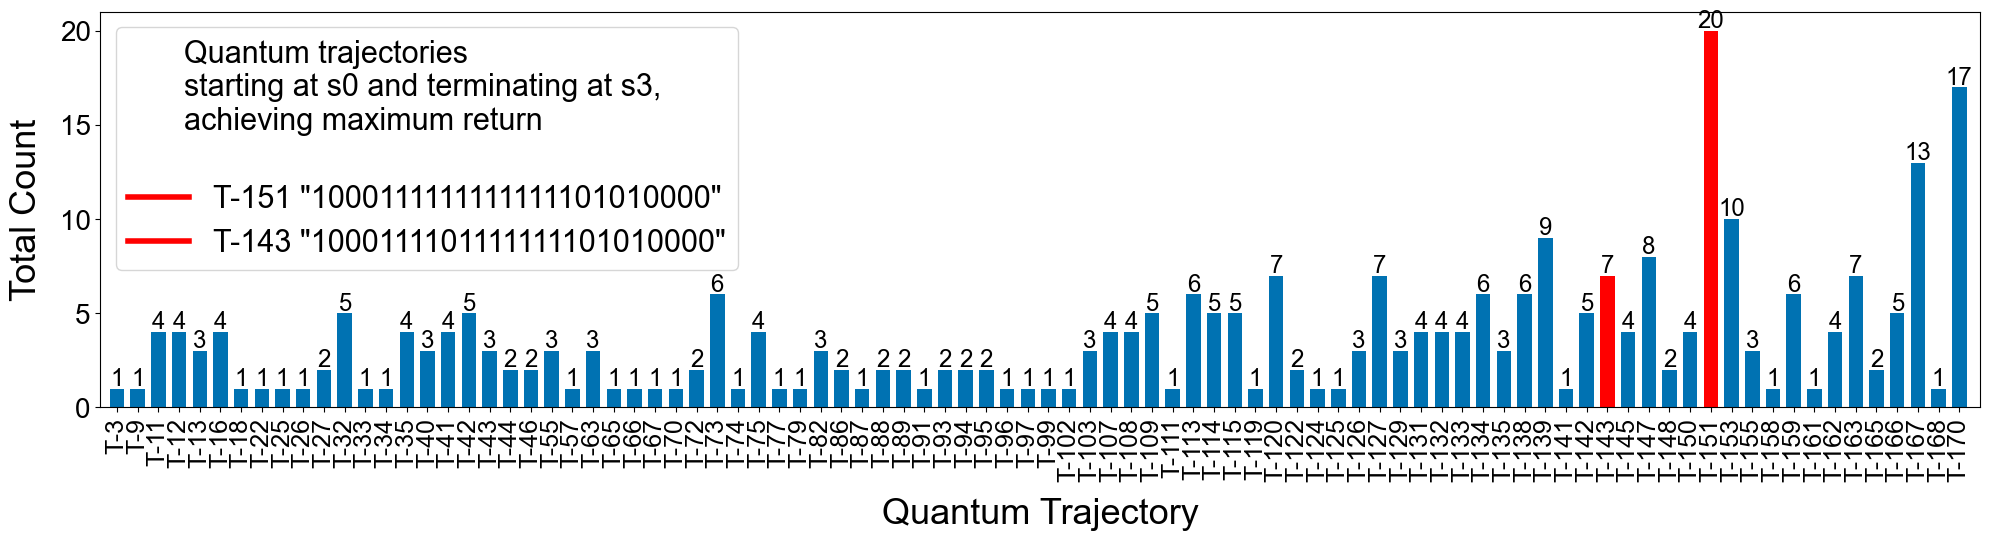

In [20]:
### x axis label changes

# Prepare data for the bar chart
qStates_mdp = list(modified_counts_mdp_sorted.keys())  # Keys from the 'modified_counts_mdp' dictionary
count_gro= [counts_Grover_sorted_1000.get(key, 0) for key in qStates_mdp]  # Get corresponding values from 'counts_grover', fill with 0 if missing

# Create a DataFrame 
df = pd.DataFrame({
    'Quantum States': qStates_mdp,
    'Count_gro': count_gro
})

df.index = range(1, len(df) + 1) # setting data frame index starting from 1 not 0

# Identify the top 10 values and their indices
top_10_indices = df.nlargest(10, 'Count_gro').index  
top_10_values = df.loc[top_10_indices]
# print('top_10_values:',top_10_values)

# Positions in the bit strings for s0 and s3(0-indexed)
qubit_positions_00 = [23, 24]
qubit_positions_11 = [0,4, 5]

# Filter function to check if the specified qubits are '00' and '11'
def filter_qubits(data, positions_s0,position_s3):
    qsample_return = {}
    for key, value in data.items():
        # Check if all specified positions have the value '00' and '11'
        if all(value[pos] == '0' for pos in positions_s0):
         if all(value[pos] == '1' for pos in position_s3):
            qsample_return[key] = value
    return qsample_return

# Apply the filter for trajectories start with s0 and terminate at s3
qsample_s0_s3 = filter_qubits(dict(top_10_values['Quantum States']), qubit_positions_00,qubit_positions_11)
# print('qsample_s0_s3:',qsample_s0_s3)

# top_colors  = ['#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000','#ff0000']
# color_map = dict(zip(top_10_indices, top_colors))
# df['Color'] = df.index.map(color_map).fillna('#0072B2')

top_colors  = ['#ff0000','#ff0000','#ff0000','#ff0000']
color_map = dict(zip(qsample_s0_s3.keys(), top_colors))
df['Color'] = df.index.map(color_map).fillna('#0072B2')

# Add an index column for sequential numbering
df['Index'] = range(1, len(df) + 1)

# Filter out rows with 'Count_gro' equal to 0
df_filtered = df[df['Count_gro'] > 0]

# make a plot
fig, ax = plt.subplots(figsize=(20, 5.5))

# Define the width of the bars 
bar_width = 0.7
# bar_width = 0.6 # pdf

# Create the bar chart
bars = ax.bar(df_filtered['Quantum States'], df_filtered['Count_gro'], color=df_filtered['Color'], width=bar_width)

# Set the labels and title
ax.set_xlabel('Quantum Trajectory', fontsize = 26, fontfamily ='Arial', labelpad= 12)
ax.set_ylabel('Total Count', fontsize = 26, fontfamily ='Arial', labelpad= 12)
# ax.set_title('Quantum Trajectories Starting at s0 and Terminating at s3, Achieving Maximum Return in a Quantum Markov Decision Process over Three Timesteps')


# Set the x-axis ticks with T+ format
t_plus_labels = [f'T-{i}' for i in df_filtered['Index']]
plt.xticks(df_filtered['Quantum States'], t_plus_labels, rotation=90, fontsize=18, fontfamily='Arial')

# # Set the y-axis ticks with intervals of 5
ax.set_yticks(range(0, int(df_filtered['Count_gro'].max()) + 1, 5))  # Tick range: 0 to max, step = 5
plt.yticks(rotation=0, fontsize=20, fontfamily='Arial')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height  - 0.1, f'{height:.0f}', ha='center', va='bottom', fontsize = 'xx-large', rotation = 0, fontfamily ='Arial')

top = qsample_s0_s3
legend_lines = [Line2D([0], [0], color=color, lw=4) for color in top_colors]
legend_labels = [f'T-{key} "{value}"' for key, value in top.items()]
ax.legend(legend_lines, legend_labels, title='Quantum trajectories \nstarting at s0 and terminating at s3, \nachieving maximum return\n',  loc='upper left', prop={'family': 'Arial','size': 22})
leg = ax.get_legend()
plt.setp(leg.get_title(), family='Arial',fontsize = 22)

# Add space on the left and right
left_padding = -0.8  # Reduce padding on the left
right_padding = len(df_filtered['Quantum States']) - 0.5 + 0.5  # Adjust padding on the right
ax.set_xlim(left_padding, right_padding)  # Apply to x-axis limits

# Show the plot
plt.tight_layout()

# plt.savefig('Quantum trajectories starting at s0 and terminating at s3 achieving maximum return_xaxis.png', dpi=800, format='png')  
# plt.savefig('Quantum trajectories starting at s0 and terminating at s3 achieving maximum return_xaxis.pdf', format='pdf')

plt.show()

---

***Grover's Search Searching '1001' Return States***

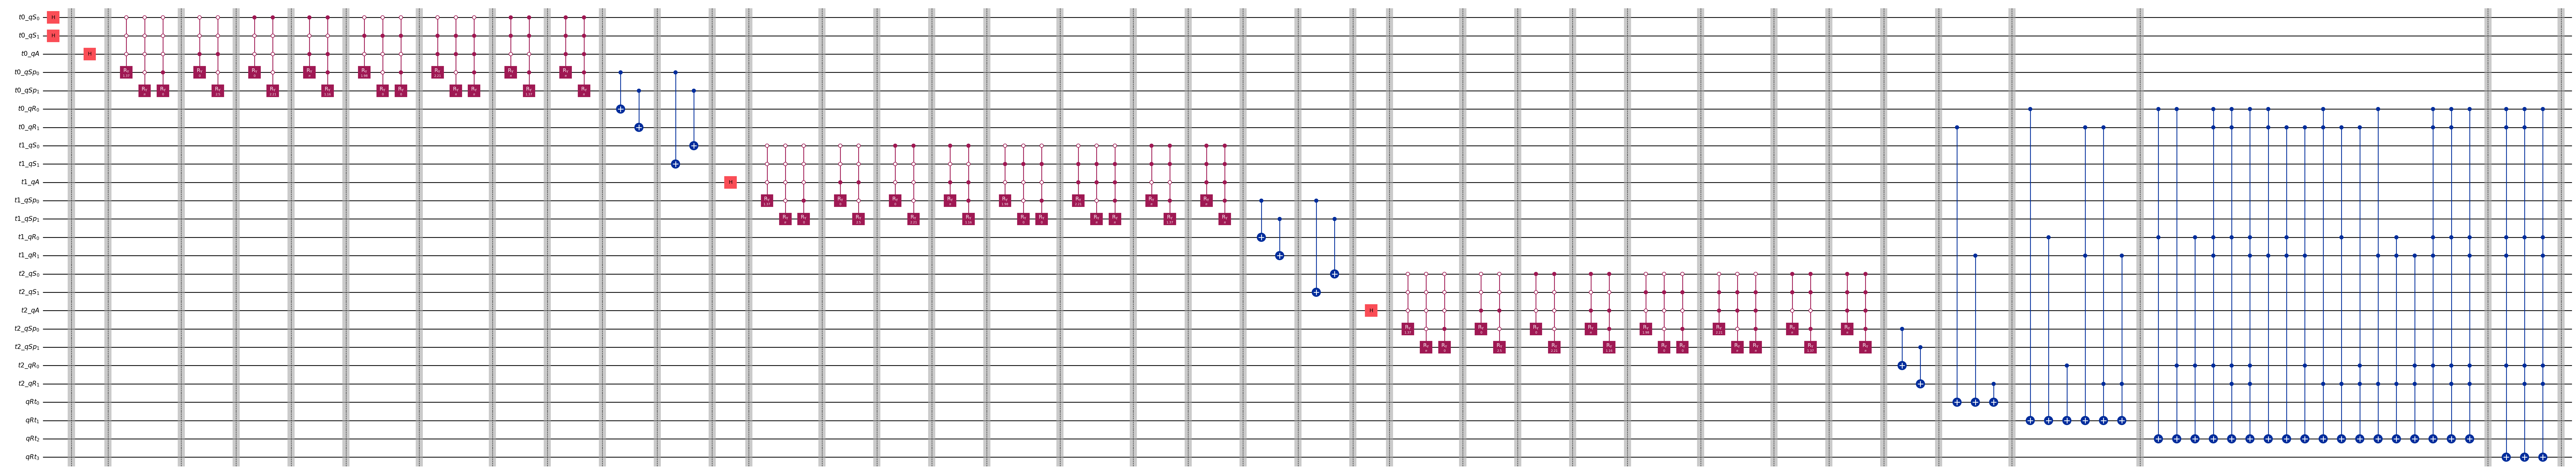

In [22]:
# Instantiate environment
env_R= QuantumToyEnv() 

### implement return function to "env" MDP circuit
__URt(env_R.qc, env_R.qR0[1], env_R.qR0[0], env_R.qR1[1],env_R.qR1[0],env_R.qR2[1],env_R.qR2[0],env_R.qRt[0],env_R.qRt[1],env_R.qRt[2],env_R.qRt[3]) 

env_R.qc.draw('mpl', fold = 1)

In [23]:
# oracle for '1001' starting states --> there are 16 total states.
qreg = QuantumRegister(4, name ='g')
oracle = QuantumCircuit(qreg, name = 'Grover')
oracle.x([1,2])
oracle.h(3)
oracle.mcx([0,1,2],3)
oracle.h(3)
oracle.x([1,2])
# oracle.draw('mpl')

In [24]:
env_R.qc = env_R.qc.compose(oracle, [env_R.qRt[0],env_R.qRt[1],env_R.qRt[2],env_R.qRt[3]])
env_R.qc.barrier()
# env_R.qc.draw('mpl')

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=25, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(2, 't0_qS'), 0), Qubit(QuantumRegister(2, 't0_qS'), 1), Qubit(QuantumRegister(1, 't0_qA'), 0), Qubit(QuantumRegister(2, 't0_qSp'), 0), Qubit(QuantumRegister(2, 't0_qSp'), 1), Qubit(QuantumRegister(2, 't0_qR'), 0), Qubit(QuantumRegister(2, 't0_qR'), 1), Qubit(QuantumRegister(2, 't1_qS'), 0), Qubit(QuantumRegister(2, 't1_qS'), 1), Qubit(QuantumRegister(1, 't1_qA'), 0), Qubit(QuantumRegister(2, 't1_qSp'), 0), Qubit(QuantumRegister(2, 't1_qSp'), 1), Qubit(QuantumRegister(2, 't1_qR'), 0), Qubit(QuantumRegister(2, 't1_qR'), 1), Qubit(QuantumRegister(2, 't2_qS'), 0), Qubit(QuantumRegister(2, 't2_qS'), 1), Qubit(QuantumRegister(1, 't2_qA'), 0), Qubit(QuantumRegister(2, 't2_qSp'), 0), Qubit(QuantumRegister(2, 't2_qSp'), 1), Qubit(QuantumRegister(2, 't2_qR'), 0), Qubit(QuantumRegister(2, 't2_qR'), 1), Qubit(QuantumRegister(4, 'qRt'), 0), Qubit(QuantumRegister(4, 'qRt'),

In [25]:
# customized diffuser
qreg = QuantumRegister(env_R.qc.num_qubits, name ='d')
diffuser = QuantumCircuit(qreg, name = 'Diffuser')
nqubits = diffuser.num_qubits

diffuser.h([nqubits-25,nqubits-24,nqubits-23])
diffuser.x([nqubits-25,nqubits-24,nqubits-23])
diffuser.h(nqubits-19)
diffuser.mcx([nqubits-25,nqubits-24,nqubits-23],nqubits-19)
diffuser.h(nqubits-19)
diffuser.h(nqubits-20)
diffuser.mcx([nqubits-25,nqubits-24,nqubits-23],nqubits-20)
diffuser.h(nqubits-20)
diffuser.x([nqubits-25,nqubits-24,nqubits-23])
diffuser.h([nqubits-25,nqubits-24,nqubits-23])
diffuser.barrier()

diffuser.h([nqubits-18,nqubits-17,nqubits-16])
diffuser.x([nqubits-18,nqubits-17,nqubits-16])
diffuser.h(nqubits-12)
diffuser.mcx([nqubits-18,nqubits-17,nqubits-16],nqubits-12)
diffuser.h(nqubits-12)
diffuser.h(nqubits-13)
diffuser.mcx([nqubits-18,nqubits-17,nqubits-16],nqubits-13)
diffuser.h(nqubits-13)
diffuser.x([nqubits-18,nqubits-17,nqubits-16])
diffuser.h([nqubits-18,nqubits-17,nqubits-16])
diffuser.barrier()

diffuser.h([nqubits-11,nqubits-10,nqubits-9])
diffuser.x([nqubits-11,nqubits-10,nqubits-9])
diffuser.h(nqubits-5)
diffuser.mcx([nqubits-11,nqubits-10,nqubits-9],nqubits-5)
diffuser.h(nqubits-5)
diffuser.h(nqubits-6)
diffuser.mcx([nqubits-11,nqubits-10,nqubits-9],nqubits-6)
diffuser.h(nqubits-6)
diffuser.x([nqubits-11,nqubits-10,nqubits-9])
diffuser.h([nqubits-11,nqubits-10,nqubits-9])
diffuser.barrier()

diffuser.h([nqubits-1,nqubits-2,nqubits-3,nqubits-4])
diffuser.mcx([nqubits-19,nqubits-20,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-1)
diffuser.mcx([nqubits-19,nqubits-20,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-2)
diffuser.mcx([nqubits-19,nqubits-20,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-3)
diffuser.mcx([nqubits-19,nqubits-20,nqubits-12,nqubits-13,nqubits-5,nqubits-6],nqubits-4)
diffuser.h([nqubits-1,nqubits-2,nqubits-3,nqubits-4])

# diffuser.draw('mpl')

In [26]:
env_R.qc = env_R.qc.compose(diffuser, env_R.qc.qubits)
# env_R.qc.draw('mpl')

In [28]:
# classical measurement
env_R.qc.measure_all()

In [31]:
backend = AerSimulator(method = 'statevector')
results_grover = backend.run(transpile(env_R.qc, backend), memory=True).result()
memory_grover = results_grover.get_memory(env_R.qc)
counts_Grover= results_grover.get_counts()    
# print(counts_Grover)
# plot_histogram(counts_Grover, title= 'Classical Measurement of Two-State Transitions -Grover Search')

In [42]:
# Correcting Next state qubits and reward qubits order
print ('counts_Grover:',counts_Grover) 

# Function to reverse the four most significant bits
def reverse_qubit_order_msb(value):
    if len(value) >= 4:
        most_significant_four = value[:4]
        rest = value[4:]
        reversed_most_significant_four = most_significant_four[::-1]
        return reversed_most_significant_four + rest
    return value

def correct_qubit_order(value):
     if len(value) >= 21:
         # return
         rt = value[:4] 
         # for t2
         t2 = value[4:11]
         t2_msb = reverse_qubit_order_msb(t2)
         # for t1
         t1 = value[11:18]
         t1_msb = reverse_qubit_order_msb(t1)
         # for t0
         t0 = value[18:]
         t0_msb = reverse_qubit_order_msb(t0)
         return rt+t2_msb+ t1_msb + t0_msb
     return value

# Create a new dictionary with modified values
modified_counts_Grover_1001 = {correct_qubit_order(key): value for key, value in counts_Grover.items()}
print('modified_counts_Grover_1001:',modified_counts_Grover_1001) ## Next state qubits and reward qubits are in correct order.

counts_Grover: {'0101101000101010100101110': 1, '0011101001101010000000010': 1, '0100000001001010100101100': 2, '0011010101010101100000001': 1, '1001111101111111111111111': 18, '0011000001001011011010100': 1, '0100010110110101111010101': 1, '1001111111111111111111110': 31, '0011010101010100110000010': 1, '0101010101001010011010010': 1, '1000111111111111100101100': 17, '0010101010000000011010010': 2, '0010101001100000011010010': 1, '0011010110010101110000010': 1, '0011000001001011011010101': 2, '1001111111111111111111101': 16, '0010101001110100000000010': 1, '1001111111111110111111111': 12, '1000111101111111100101001': 7, '1000111111111111100101010': 1, '1000010101011111111111110': 3, '0110010100001010100101001': 2, '0101010110110101100101111': 1, '0110010100101010100101110': 2, '0110010101111111011010010': 3, '0110010110011111011010111': 1, '0111010100011111100101111': 1, '0011101010100000100101111': 1, '0011010110110101000000010': 1, '0111111111001010100101111': 10, '01110101011111111

In [44]:
eligible_classical_states = list(modified_counts_mdp.keys())
len(eligible_classical_states)

170

In [48]:
modified_filtered_counts_Grover= {key: value for key, value in modified_counts_Grover_1001.items() if key in eligible_classical_states}
# print('filtered_classical_measurement:',len(modified_filtered_counts_Grover))

modified_counts_Grover_sorted = dict(sorted(modified_filtered_counts_Grover.items(), key= lambda item: item[1], reverse= False))
# modified_counts_Grover_sorted

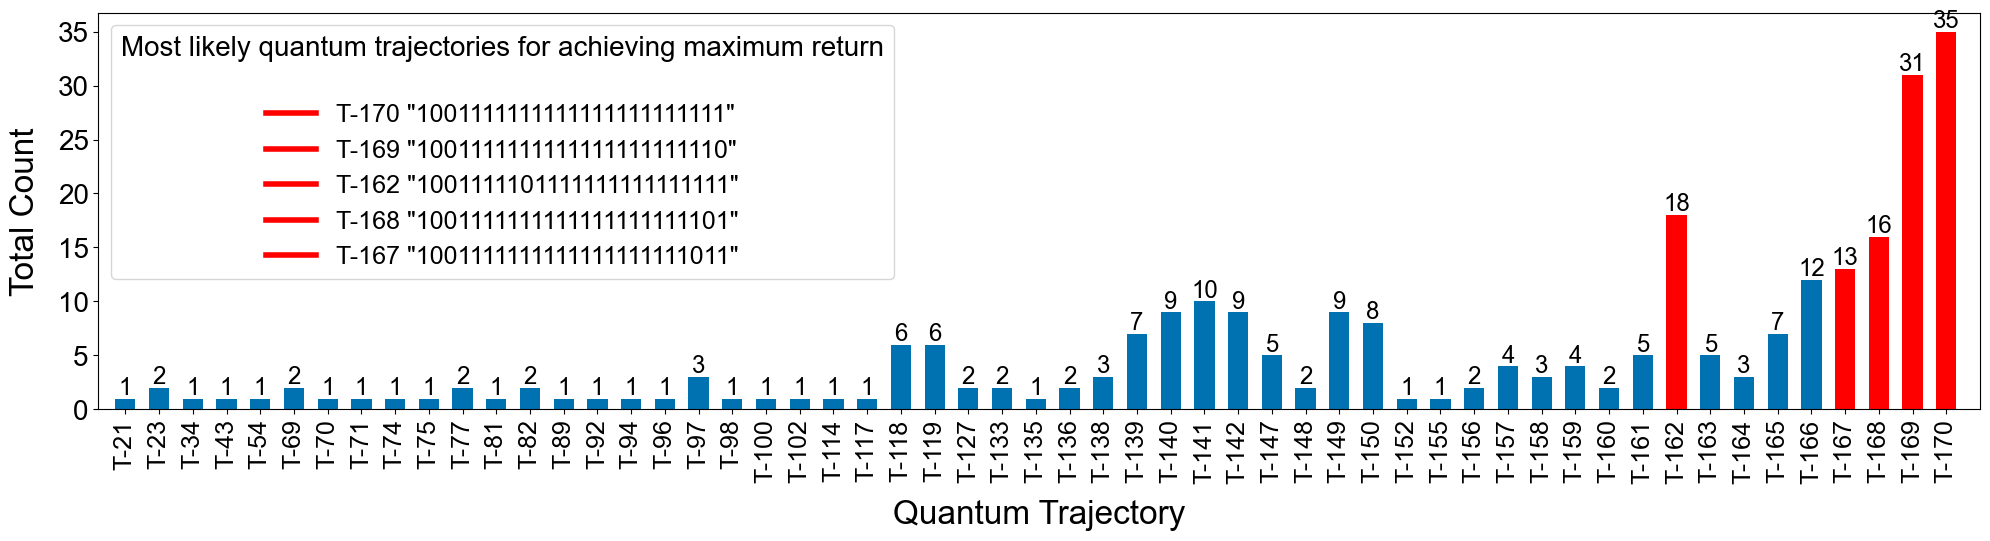

In [49]:
###x axis change

from matplotlib.lines import Line2D

# Prepare data for the bar chart
qStates_mdp = list(modified_counts_mdp_sorted.keys())  # Keys from the 'counts_mdp_sorted' dictionary
count_gro = [modified_counts_Grover_sorted.get(key, 0) for key in qStates_mdp]  # Get corresponding values from 'modified_counts_grover', fill with 0 if missing

# Create a DataFrame
df = pd.DataFrame({
    'Quantum States': qStates_mdp,
    'Count_gro': count_gro
})

df.index = range(1, len(df) + 1) # setting data frame index starting from 1 not 0

# Add an index column for sequential numbering
df['Index'] = range(1, len(df) + 1)

# Identify the top 10 values and their indices
top_10_indices = df.nlargest(10, 'Count_gro').index
top_10_values = df.loc[top_10_indices]
# print('top_10_values:\n', top_10_values)

# Identify the top 5 values and their indices
top_5_indices = df.nlargest(5, 'Count_gro').index
top_5_values = df.loc[top_5_indices]

# Define top colors
top_colors = ['#ff0000', '#ff0000', '#ff0000', '#ff0000', '#ff0000']
color_map = dict(zip(top_5_indices, top_colors))
df['Color'] = df.index.map(color_map).fillna('#0072B2')

# Filter out rows with 'Count_gro' equal to 0
df_filtered = df[df['Count_gro'] > 0]

# Make a plot
fig, ax = plt.subplots(figsize=(20, 5.5))

# Define the width of the bars
bar_width = 0.6

# Create the bar chart
bars = ax.bar(df_filtered['Quantum States'], df_filtered['Count_gro'], color=df_filtered['Color'], width=bar_width)

# Set the labels and title
ax.set_xlabel('Quantum Trajectory', fontsize=24, fontfamily='Arial', labelpad=12)
ax.set_ylabel('Total Count', fontsize=24, fontfamily='Arial', labelpad=12)


# Set the x-axis ticks with T+ format
t_plus_labels = [f'T-{i}' for i in df_filtered['Index']]
plt.xticks(df_filtered['Quantum States'], t_plus_labels, rotation=90, fontsize=18, fontfamily='Arial')

# # Set the y-axis ticks with intervals of 5
ax.set_yticks(range(0, int(df_filtered['Count_gro'].max()) + 1, 5))  # Tick range: 0 to max, step = 5
plt.yticks(rotation=0, fontsize=20, fontfamily='Arial')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height - 0.1, f'{height:.0f}', ha='center', va='bottom', fontsize='xx-large', rotation=0, fontfamily='Arial')
    

# # # Create legend labels with T-numbers
legend_lines = [Line2D([0], [0], color='#ff0000', lw=4) for _ in legend_labels]
legend_labels = [f'T-{row.Index} "{row["Quantum States"]}"' for _, row in top_5_values.iterrows()]
ax.legend(legend_lines, legend_labels, title='Most likely quantum trajectories for achieving maximum return\n', loc='upper left', prop={'family': 'Arial', 'size': 18})

# Customize legend title font
leg = ax.get_legend()
plt.setp(leg.get_title(), family='Arial', fontsize=20)

# Add space on the left and right
left_padding = -0.8  # Reduce padding on the left
right_padding = len(df_filtered['Quantum States']) - 0.5 + 0.5  # Adjust padding on the right
ax.set_xlim(left_padding, right_padding)  # Apply to x-axis limits

# # Show the plot
plt.tight_layout()

# plt.savefig('Quantum trajectories starting at Any State and terminating at s3 achieving maximum return_xaxis.png', dpi=800, format='png')  
# plt.savefig('Quantum trajectories starting at Any State and terminating at s3 achieving maximum return_xaxis.pdf', format='pdf')  

plt.show()


---